# Deep Learning Term Project for ECG (DIL700)

# Iteration 4

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [2]:
train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Remove class 3 and replace class 4 for 3

In [3]:
train_df = train_df[train_df[187] != 3]
test_df = test_df[test_df[187] != 3]
full_df = full_df[full_df[187] != 3]

train_df.loc[train_df[187] == 4, 187] = 3
test_df.loc[test_df[187] == 4, 187] = 3
full_df.loc[full_df[187] == 4, 187] = 3

## Converting dataset into Normal/abnormal instead of 5 classes

In [4]:
train_df.loc[train_df[187] == 3, 187] = 1
test_df.loc[test_df[187] == 3, 187] = 1
full_df.loc[full_df[187] == 3, 187] = 1

train_df.loc[train_df[187] == 2, 187] = 1
test_df.loc[test_df[187] == 2, 187] = 1
full_df.loc[full_df[187] == 2, 187] = 1

In [5]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [6]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
print(train_df[187].unique())

[0. 1.]


In [8]:
labels = ['Normal', 'Abnormal']
labels_short =  ["N","A"]

In [9]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
# print(labels[2],':', len(train_df[train_df[187]==2]))
# print(labels[3],':', len(train_df[train_df[187]==3]))
# print(labels[4],':', len(train_df[train_df[187]==4]))

Number of samples in data:
Normal : 72471
Abnormal : 14442


In [10]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
# print(labels[2],':', len(test_df[test_df[187]==2]))
# print(labels[3],':', len(test_df[test_df[187]==3]))
# print(labels[4],':', len(test_df[test_df[187]==4]))

Number of samples in data:
Normal : 18118
Abnormal : 3612


## Preparation

In [11]:
X_train = test_df.iloc[:, :-1]
y_train = test_df.iloc[:, -1]

In [12]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
y_train

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21887    1.0
21888    1.0
21889    1.0
21890    1.0
21891    1.0
Name: 187, Length: 21730, dtype: float64

## Dataset Distribution

### Full set

In [14]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    72471
1    14442
Name: 187, dtype: int64


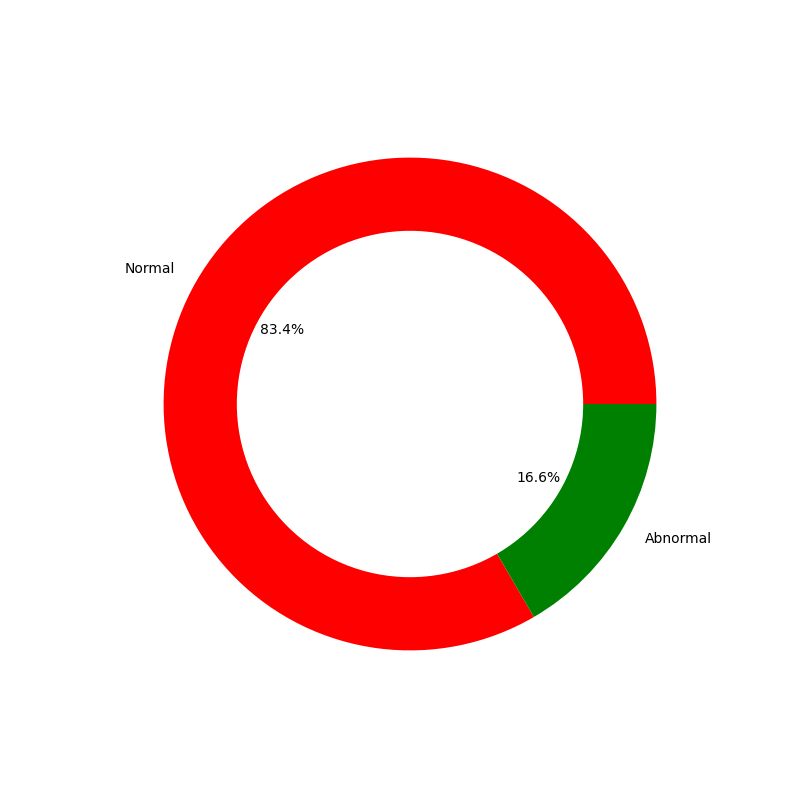

In [15]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Load first model

In [16]:
# load cnn model with h5 and json file
from keras.models import model_from_json
json_file = open('saved_models/CNN_MITBIH_Part_1_21032023_164841/CNN_MITBIH_Part_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_1= model_from_json(loaded_model_json)

# Then load the weights
model_1.load_weights("saved_models/CNN_MITBIH_Part_1_21032023_164841/CNN_MITBIH_Part_1.h5")

In [17]:
# Predict test set labels
y_pred_1  = model_1.predict(X_train)
y_pred_model_1 = np.where(y_pred_1 > 0.5, 1, 0)

print('Accuracy of CNN: ', accuracy_score(y_train, y_pred_model_1))

680/680 [==============================] - 4s 2ms/step
Accuracy of CNN:  0.9880809940174874


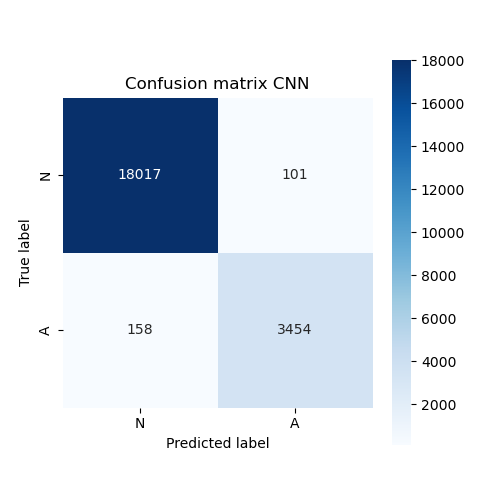

In [18]:
# Calculate confusion matrix
cm = confusion_matrix(y_train, y_pred_model_1)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [19]:
print(classification_report(y_train, y_pred_model_1, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9913    0.9944    0.9929     18118
    Abnormal     0.9716    0.9563    0.9639      3612

    accuracy                         0.9881     21730
   macro avg     0.9814    0.9753    0.9784     21730
weighted avg     0.9880    0.9881    0.9880     21730



# Load second model

In [20]:
# load cnn model with h5 and json file
from keras.models import model_from_json
json_file = open('saved_models/CNN_MITBIH_Part_2_21032023_193449/CNN_MITBIH_Part_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_2= model_from_json(loaded_model_json)

# Then load the weights
model_2.load_weights("saved_models/CNN_MITBIH_Part_2_21032023_193449/CNN_MITBIH_Part_2.h5")

# Test which classes are not classified as abnormal

In [21]:
train_df_2=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df_2=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df_2=pd.concat([train_df_2,test_df_2],ignore_index=True)


In [22]:
train_df_2 = train_df_2[train_df_2[187] != 3]
test_df_2 = test_df_2[test_df_2[187] != 3]
full_df_2 = full_df_2[full_df_2[187] != 3]

train_df_2.loc[train_df_2[187] == 4, 187] = 3
test_df_2.loc[test_df_2[187] == 4, 187] = 3
full_df_2.loc[full_df_2[187] == 4, 187] = 3

In [23]:
# copy the rows of full_df where the prediction of y_pred_cnn is 1
abnormal_df = test_df_2[y_pred_model_1 == 1]

In [24]:
X_train_abnormal = abnormal_df.iloc[:, :-1]
y_train_abnormal = abnormal_df.iloc[:, -1]

In [33]:
# Predict test set labels
y_pred_2  = model_2.predict(X_train_abnormal)
y_pred_model_2 = np.argmax(y_pred_2 , axis=1)


112/112 [==============================] - 0s 3ms/step


In [34]:
# Store the predicted labels in a dataframe
y_pred_df_abnormal = pd.DataFrame(y_pred_model_2, columns=['Predicted'])
y_pred_df_abnormal = y_pred_df_abnormal.set_index(abnormal_df.index)
# All values in the dataframe are column predicted plus 1
y_pred_df_abnormal = y_pred_df_abnormal + 1

In [35]:
y_pred_df = pd.DataFrame(data=0, index=test_df_2.index, columns=['Predicted'])


In [36]:
y_pred_df['Predicted'] = y_pred_df_abnormal['Predicted']
y_pred_df['Predicted'].fillna(0, inplace=True)

## Check performance

In [37]:
print('Accuracy of CNN: ', accuracy_score(test_df_2[187], y_pred_df['Predicted']))

Accuracy of CNN:  0.9859180855959503


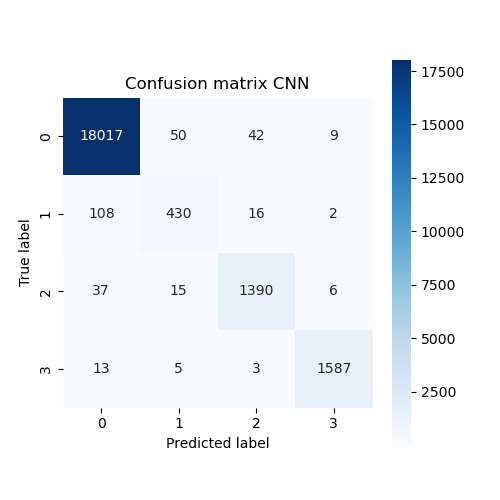

In [38]:
# Calculate confusion matrix
cm = confusion_matrix(test_df_2[187], y_pred_df['Predicted'])

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
# ax.xaxis.set_ticklabels(labels_short)
# ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [39]:
labels = ['Normal','Artial Premature', 'Premature ventricular contraction', 'Paced']
print(classification_report(test_df_2[187], y_pred_df['Predicted'], target_names=labels, digits=4))

                                   precision    recall  f1-score   support

                           Normal     0.9913    0.9944    0.9929     18118
                 Artial Premature     0.8600    0.7734    0.8144       556
Premature ventricular contraction     0.9580    0.9599    0.9590      1448
                            Paced     0.9894    0.9869    0.9882      1608

                         accuracy                         0.9859     21730
                        macro avg     0.9497    0.9287    0.9386     21730
                     weighted avg     0.9856    0.9859    0.9857     21730

